# Real Sunspot data

In [10]:
import csv
import numpy as np

time_step = []
sunspots = []

with open('data/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

print(len(sunspots))
print(len(time_step))

3265
3265


In [11]:
sunspots = np.array(sunspots)
time_step = np.array(time_step)

In [12]:
import matplotlib.pyplot as plt

def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

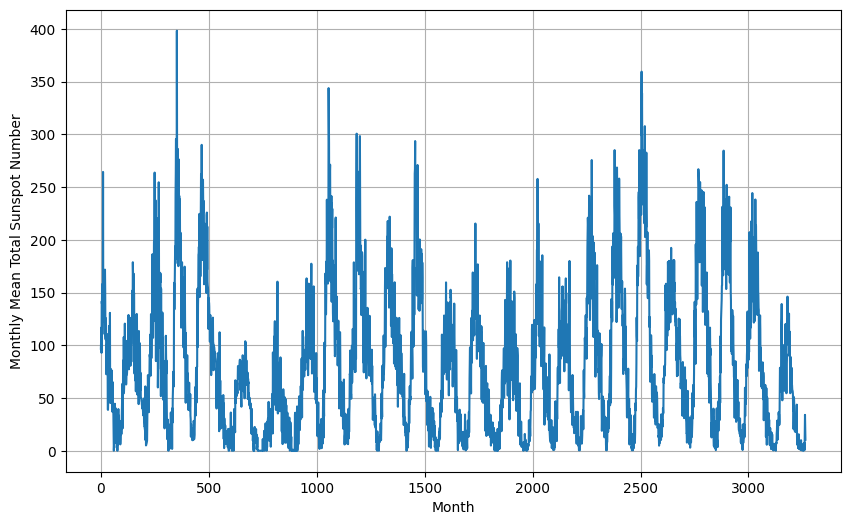

In [13]:
plot_series(time_step, sunspots, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

# Split the dataset

In [14]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time_step[:split_time]
x_train = sunspots[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = sunspots[split_time:]

In [15]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [16]:
# Parameters
window_size = 60a
batch_size = 30
shuffle_buffer_size = 1000

# Generate the dataset windows
x_train = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Train the model

In [17]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=30, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()
init_weights = model.get_weights()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 32)            128       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            24832     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

### Tuning the lr

In [19]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

# Train the model
history = model.fit(x_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 5s 22ms/step - loss: 66.8199 - mae: 67.3173 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 2s 23ms/step - loss: 40.6412 - mae: 41.1389 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 3s 35ms/step - loss: 33.6251 - mae: 34.1211 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 2s 22ms/step - loss: 29.9245 - mae: 30.4211 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 3s 30ms/step - loss: 28.0734 - mae: 28.5690 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 5s 51ms/step - loss: 26.8948 - mae: 27.3907 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 34ms/step - loss: 25.9509 - mae: 26.4454 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 3s 29ms/step - loss: 25.1137 - mae: 25.6085 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 2s 24ms/step - loss: 24.2976 - mae:

(1e-08, 0.001, 0.0, 100.0)

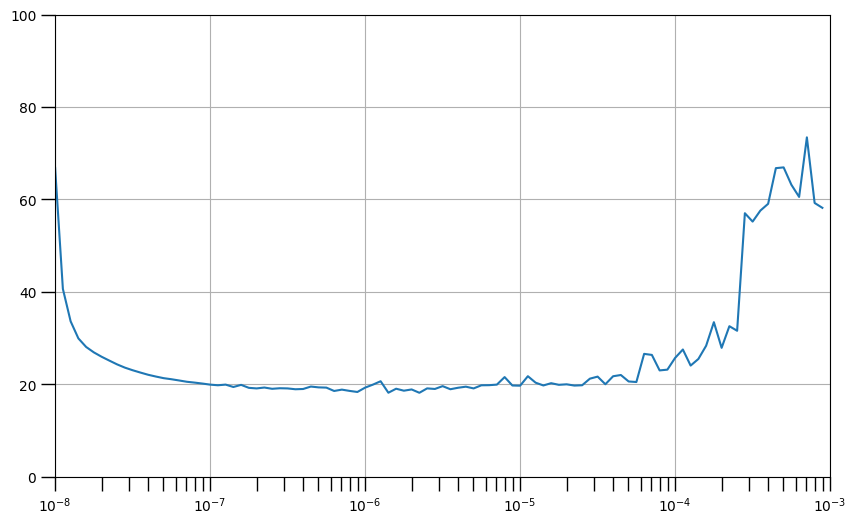

In [20]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [21]:
op_epoch = np.argmin(history.history['loss']) + 1
print(op_epoch)
print(np.min(history.history['loss']))

Optimal_lr = 1e-8 * 10**(op_epoch/20)
print(Optimal_lr)

48
18.153207778930664
2.5118864315095797e-06


In [22]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=Optimal_lr, momentum=0.9),
    metrics=['mae'])

In [23]:
history = model.fit(x_train,epochs=100)

Epoch 1/100
93/93 [==============================] - 7s 24ms/step - loss: 28.1299 - mae: 28.6245
Epoch 2/100
93/93 [==============================] - 2s 23ms/step - loss: 21.7783 - mae: 22.2726
Epoch 3/100
93/93 [==============================] - 2s 22ms/step - loss: 20.1587 - mae: 20.6516
Epoch 4/100
93/93 [==============================] - 2s 22ms/step - loss: 19.9058 - mae: 20.3976
Epoch 5/100
93/93 [==============================] - 2s 23ms/step - loss: 20.2858 - mae: 20.7775
Epoch 6/100
93/93 [==============================] - 2s 22ms/step - loss: 20.8599 - mae: 21.3531
Epoch 7/100
93/93 [==============================] - 2s 22ms/step - loss: 20.1594 - mae: 20.6519
Epoch 8/100
93/93 [==============================] - 2s 22ms/step - loss: 18.7144 - mae: 19.2079
Epoch 9/100
93/93 [==============================] - 2s 22ms/step - loss: 19.4051 - mae: 19.8981
Epoch 10/100
93/93 [==============================] - 2s 22ms/step - loss: 19.4337 - mae: 19.9284
Epoch 11/100
93/93 [=========

# Model Evaluation

In [24]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

9/9 [==============================] - 1s 6ms/step


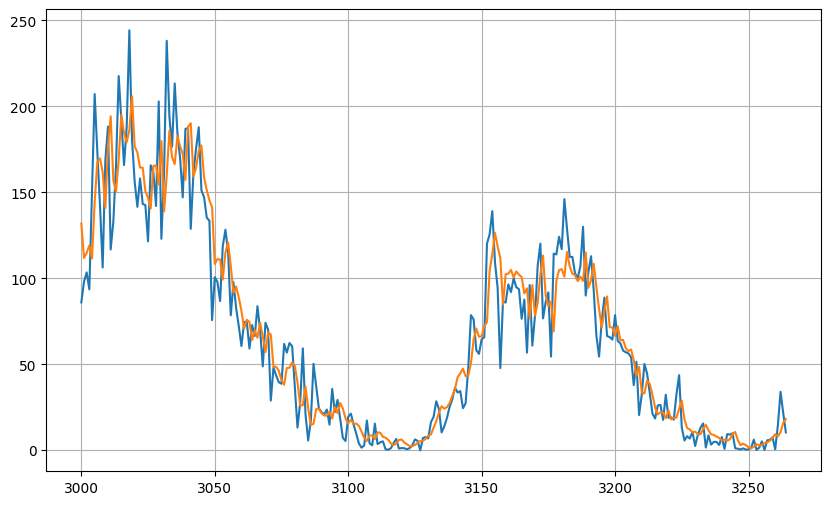

In [25]:
# Reduce the original series
forecast_series = sunspots[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [26]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

13.282492
